# Comparison of Linear System Solvers

In this notebook, we compare the Thomas algorithm with other popular techniques for solving linear systems:

1. **Direct Methods:**
   - Thomas Algorithm (specialized tridiagonal)
   - LU Decomposition (general)
   - Cholesky Decomposition (symmetric positive definite)
   - Sparse LU (scipy.sparse)

2. **Iterative Methods:**
   - Jacobi
   - Gauss-Seidel
   - Conjugate Gradient (CG)
   - BiCGSTAB

## Goals
- Understand when each method is most appropriate
- Compare performance, accuracy, and memory usage
- Identify trade-offs between different approaches

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from pathlib import Path
sys.path.append('../src')

from linear_systems import (
    build_tridiagonal,
    build_discrete_laplacian_1d,
    tridiagonal_solve,
    compute_residual
)

from scipy import sparse
from scipy.sparse.linalg import spsolve, cg, bicgstab, splu
from scipy.linalg import lu_factor, lu_solve, cho_factor, cho_solve

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

print("Setup complete!")

Setup complete!


## 1. Direct Method Comparison

In [18]:
# Implement iterative methods for comparison
def jacobi_solve(A, b, max_iter=1000, tol=1e-10):
    """Jacobi iterative method"""
    n = len(b)
    x = np.zeros(n)
    D = np.diag(np.diag(A))
    R = A - D
    D_inv = np.diag(1.0 / np.diag(A))
    
    for iteration in range(max_iter):
        x_new = D_inv @ (b - R @ x)
        if np.linalg.norm(x_new - x) < tol:
            return x_new, iteration + 1
        x = x_new
    
    return x, max_iter

def gauss_seidel_solve(A, b, max_iter=1000, tol=1e-10):
    """Gauss-Seidel iterative method"""
    n = len(b)
    x = np.zeros(n)
    
    for iteration in range(max_iter):
        x_new = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x_new[:i])
            sum2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = (b[i] - sum1 - sum2) / A[i, i]
        
        if np.linalg.norm(x_new - x) < tol:
            return x_new, iteration + 1
        x = x_new
    
    return x, max_iter

print("Iterative solvers implemented!")

Iterative solvers implemented!


In [19]:
# Compare direct methods
sizes = [100, 200, 500, 1000, 2000]
methods_direct = ['Thomas', 'Dense LU', 'Sparse LU', 'Cholesky']
times_direct = {method: [] for method in methods_direct}
memory_direct = {method: [] for method in methods_direct}

print("=" * 80)
print("DIRECT METHOD COMPARISON".center(80))
print("=" * 80)
print(f"{'Size':>6} {'Thomas':>12} {'Dense LU':>12} {'Sparse LU':>12} {'Cholesky':>12}")
print("-" * 80)

for n in sizes:
    # Build system
    d, u, o = build_discrete_laplacian_1d(n)
    A_dense = build_tridiagonal(d, u, o)
    b = np.random.randn(n)
    
    # Make symmetric positive definite for Cholesky
    A_spd = A_dense.T @ A_dense + np.eye(n)
    b_spd = A_dense.T @ b
    
    # Sparse matrix
    A_sparse = sparse.diags([u, d, o], [-1, 0, 1], format='csr')
    
    # Thomas Algorithm
    start = time.perf_counter()
    x_thomas = tridiagonal_solve(d.copy(), u.copy(), o.copy(), b.copy())
    time_thomas = time.perf_counter() - start
    times_direct['Thomas'].append(time_thomas * 1000)
    memory_direct['Thomas'].append((2*n - 1) * 8 / 1e6)
    
    # Dense LU
    start = time.perf_counter()
    lu, piv = lu_factor(A_dense)
    x_lu = lu_solve((lu, piv), b)
    time_lu = time.perf_counter() - start
    times_direct['Dense LU'].append(time_lu * 1000)
    memory_direct['Dense LU'].append(n * n * 8 / 1e6)
    
    # Sparse LU
    start = time.perf_counter()
    x_sparse = spsolve(A_sparse, b)
    time_sparse = time.perf_counter() - start
    times_direct['Sparse LU'].append(time_sparse * 1000)
    memory_direct['Sparse LU'].append((3*n) * 8 / 1e6)  # Approximate
    
    # Cholesky
    start = time.perf_counter()
    cho, lower = cho_factor(A_spd)
    x_cho = cho_solve((cho, lower), b_spd)
    time_cho = time.perf_counter() - start
    times_direct['Cholesky'].append(time_cho * 1000)
    memory_direct['Cholesky'].append(n * n * 8 / 2e6)  # Only store triangle
    
    print(f"{n:6d} {time_thomas*1000:12.4f} {time_lu*1000:12.4f} {time_sparse*1000:12.4f} {time_cho*1000:12.4f}")

print("=" * 80)

                            DIRECT METHOD COMPARISON                            
  Size       Thomas     Dense LU    Sparse LU     Cholesky
--------------------------------------------------------------------------------
   100       0.2632       0.2568       0.2274       0.6757
   200       0.8461      64.5439       0.2736      30.3438
   500       3.0721      18.7852       0.8726      19.7769


  1000       4.1683     127.0204       0.6233      19.9279
  2000       5.5203     269.8142       1.1202     172.2962
  2000       5.5203     269.8142       1.1202     172.2962


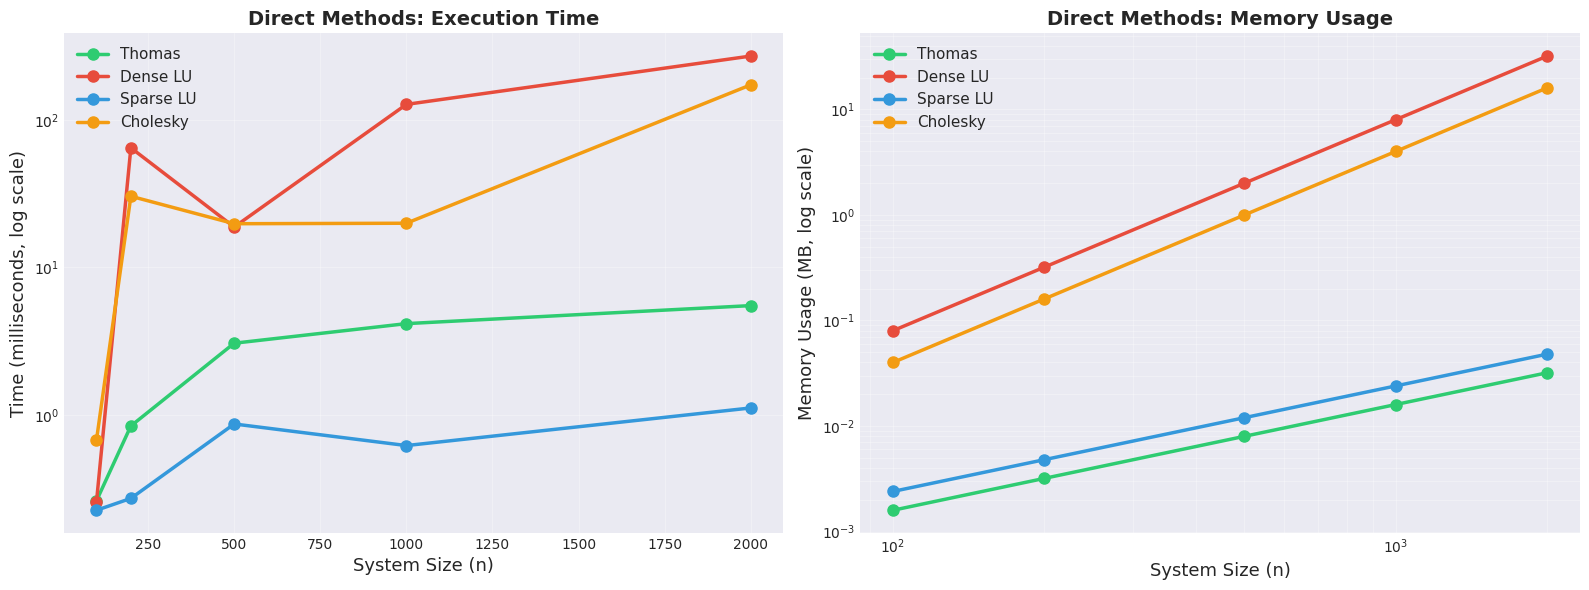

In [20]:
# Visualize direct method comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Timing comparison
colors = {'Thomas': '#2ecc71', 'Dense LU': '#e74c3c', 'Sparse LU': '#3498db', 'Cholesky': '#f39c12'}
for method in methods_direct:
    ax1.semilogy(sizes, times_direct[method], 'o-', linewidth=2.5, markersize=8,
                 label=method, color=colors[method])

ax1.set_xlabel('System Size (n)', fontsize=13)
ax1.set_ylabel('Time (milliseconds, log scale)', fontsize=13)
ax1.set_title('Direct Methods: Execution Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3)

# Memory comparison
for method in methods_direct:
    ax2.loglog(sizes, memory_direct[method], 'o-', linewidth=2.5, markersize=8,
               label=method, color=colors[method])

ax2.set_xlabel('System Size (n)', fontsize=13)
ax2.set_ylabel('Memory Usage (MB, log scale)', fontsize=13)
ax2.set_title('Direct Methods: Memory Usage', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.95)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../figures/direct_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Iterative Method Comparison

In [21]:
# Compare iterative methods
sizes_iter = [100, 200, 500, 1000]
methods_iter = ['Jacobi', 'Gauss-Seidel', 'Conjugate Gradient', 'BiCGSTAB']
times_iter = {method: [] for method in methods_iter}
iterations_iter = {method: [] for method in methods_iter}

print("\n" + "=" * 90)
print("ITERATIVE METHOD COMPARISON".center(90))
print("=" * 90)
print(f"{'Size':>6} {'Jacobi (it)':>15} {'G-Seidel (it)':>17} {'CG (it)':>15} {'BiCGSTAB (it)':>17}")
print("-" * 90)

for n in sizes_iter:
    # Build system
    d, u, o = build_discrete_laplacian_1d(n)
    A_dense = build_tridiagonal(d, u, o)
    b = np.random.randn(n)
    A_sparse = sparse.csr_matrix(A_dense)
    
    # Jacobi
    start = time.perf_counter()
    x_jacobi, iters_jacobi = jacobi_solve(A_dense, b)
    time_jacobi = time.perf_counter() - start
    times_iter['Jacobi'].append(time_jacobi * 1000)
    iterations_iter['Jacobi'].append(iters_jacobi)
    
    # Gauss-Seidel
    start = time.perf_counter()
    x_gs, iters_gs = gauss_seidel_solve(A_dense, b)
    time_gs = time.perf_counter() - start
    times_iter['Gauss-Seidel'].append(time_gs * 1000)
    iterations_iter['Gauss-Seidel'].append(iters_gs)
    
    # Conjugate Gradient
    class CGCounter:
        def __init__(self):
            self.count = 0
        def __call__(self, x):
            self.count += 1
    
    cg_counter = CGCounter()
    start = time.perf_counter()
    x_cg, info_cg = cg(A_sparse, b, rtol=1e-10, atol=0, callback=cg_counter)
    time_cg = time.perf_counter() - start
    times_iter['Conjugate Gradient'].append(time_cg * 1000)
    iterations_iter['Conjugate Gradient'].append(cg_counter.count)
    
    # BiCGSTAB
    class BiCGCounter:
        def __init__(self):
            self.count = 0
        def __call__(self, x):
            self.count += 1
    
    bicg_counter = BiCGCounter()
    start = time.perf_counter()
    x_bicg, info_bicg = bicgstab(A_sparse, b, rtol=1e-10, atol=0, callback=bicg_counter)
    time_bicg = time.perf_counter() - start
    times_iter['BiCGSTAB'].append(time_bicg * 1000)
    iterations_iter['BiCGSTAB'].append(bicg_counter.count)
    
    print(f"{n:6d} {iters_jacobi:8d} ({time_jacobi*1000:6.2f}ms) "
          f"{iters_gs:8d} ({time_gs*1000:6.2f}ms) "
          f"{cg_counter.count:8d} ({time_cg*1000:6.2f}ms) "
          f"{bicg_counter.count:8d} ({time_bicg*1000:6.2f}ms)")

print("=" * 90)


                               ITERATIVE METHOD COMPARISON                                
  Size     Jacobi (it)     G-Seidel (it)         CG (it)     BiCGSTAB (it)
------------------------------------------------------------------------------------------


   100     1000 ( 20.05ms)     1000 (398.66ms)      100 (  2.84ms)      112 (  3.97ms)
   200     1000 ( 13.98ms)     1000 (650.81ms)      200 (  6.78ms)      212 ( 16.15ms)
   200     1000 ( 13.98ms)     1000 (650.81ms)      200 (  6.78ms)      212 ( 16.15ms)
   500     1000 (148.18ms)     1000 (1522.37ms)      500 ( 16.21ms)      522 ( 34.07ms)
   500     1000 (148.18ms)     1000 (1522.37ms)      500 ( 16.21ms)      522 ( 34.07ms)
  1000     1000 (811.90ms)     1000 (3289.11ms)     1000 ( 25.86ms)     1140 ( 50.64ms)
  1000     1000 (811.90ms)     1000 (3289.11ms)     1000 ( 25.86ms)     1140 ( 50.64ms)


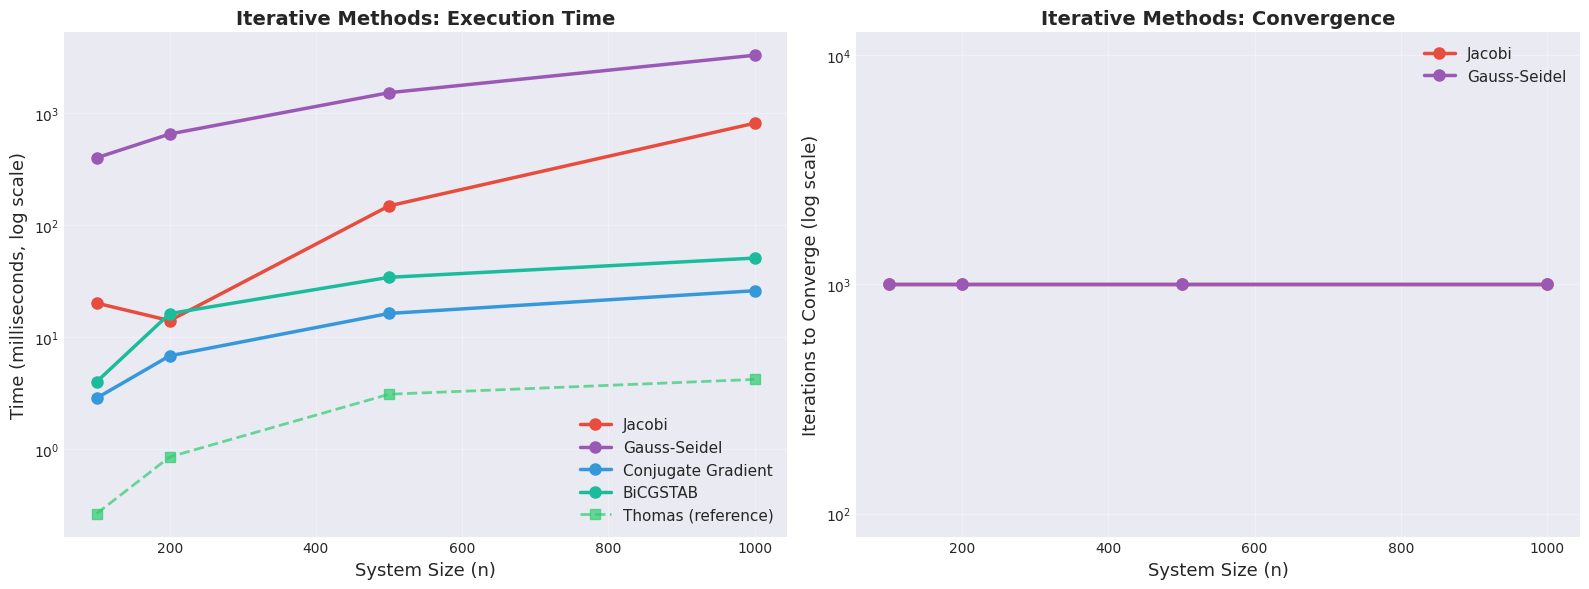

In [22]:
# Visualize iterative method comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors_iter = {'Jacobi': '#e74c3c', 'Gauss-Seidel': '#9b59b6', 
               'Conjugate Gradient': '#3498db', 'BiCGSTAB': '#1abc9c'}

# Timing
for method in methods_iter:
    ax1.semilogy(sizes_iter, times_iter[method], 'o-', linewidth=2.5, markersize=8,
                 label=method, color=colors_iter[method])

# Add Thomas for reference
thomas_ref = [times_direct['Thomas'][i] for i in range(len(sizes_iter))]
ax1.semilogy(sizes_iter, thomas_ref, 's--', linewidth=2, markersize=7,
             label='Thomas (reference)', color='#2ecc71', alpha=0.7)

ax1.set_xlabel('System Size (n)', fontsize=13)
ax1.set_ylabel('Time (milliseconds, log scale)', fontsize=13)
ax1.set_title('Iterative Methods: Execution Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3)

# Iterations
for method in ['Jacobi', 'Gauss-Seidel']:
    ax2.semilogy(sizes_iter, iterations_iter[method], 'o-', linewidth=2.5, markersize=8,
                 label=method, color=colors_iter[method])

ax2.set_xlabel('System Size (n)', fontsize=13)
ax2.set_ylabel('Iterations to Converge (log scale)', fontsize=13)
ax2.set_title('Iterative Methods: Convergence', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.95)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/iterative_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Summary: When to Use Each Method

### Direct Methods

| Method | Best For | Complexity | Memory | Notes |
|--------|----------|------------|--------|-------|
| **Thomas** | Tridiagonal systems | O(n) | O(n) | ⭐ Fastest for tridiagonal |
| **Sparse LU** | General sparse systems | O(n) to O(n³) | O(nnz) | Good for arbitrary sparsity |
| **Dense LU** | Small dense systems | O(n³) | O(n²) | General purpose |
| **Cholesky** | Symmetric positive definite | O(n³/2) | O(n²/2) | Faster than LU for SPD |

### Iterative Methods

| Method | Best For | Per Iteration | Convergence | Notes |
|--------|----------|---------------|-------------|-------|
| **Jacobi** | Diagonally dominant | O(n²) | Slow | Simple, parallelizable |
| **Gauss-Seidel** | Diagonally dominant | O(n²) | Faster than Jacobi | Sequential |
| **Conjugate Gradient** | SPD systems | O(n²) | Fast | ⭐ Best for large SPD |
| **BiCGSTAB** | Non-symmetric | O(n²) | Fast | General iterative |

### Recommendations

**For tridiagonal systems:** Use Thomas algorithm (specialized, fastest)

**For general sparse systems:**
- Small/medium (n < 10,000): Sparse LU
- Large (n > 10,000): Iterative methods (CG if SPD, BiCGSTAB otherwise)

**For dense systems:**
- Small (n < 1,000): Dense LU or Cholesky
- Large: Avoid if possible, consider iterative methods